# **ML Modelling and Interpretation**

## Objectives

1. Perform hyperparameter selection
2. Train model
3. Interpret results
4. Extract cluster insights

## Inputs

- dbscan_input.csv file, for model training
- acled_clean.csv file, for insights extraction

## Outputs

1. Clustering model, saved as pickle file
2. Set of conflict cluster insights

## Additional Comments

<ins>Why DBSCAN?</ins>

DBSCAN is a density-based clustering algorithm that groups data points that are closely packed together and marks outliers as noise based on their density in the feature space.

Whilst K-Means and hierarchical clustering assume that clusters are compact and spherical, DBSCAN is better at handling real-life irregularities, such as:
- Clusters shaped arbitrarily, no need for perfectly circular or convex shapes
- Noise and outliers, it can identify noise/outliers and treat them separately, rather than squeezing them into the clusters

Given the ACLED dataset and the project's goal, here are some specific advantages:
1. Conflict events vary in shape and size, a one-size-fits-all won't work here
2. DBSCAN can automatically detect number of clusters, which given the exploratory nature of our goal, is ideal
3. ACLED is very noisy, DBSCAN is robust to noise
4. DBSCAN is known to handle geographical data (long/lat) well
5. The use of DBSCAN in modelling conflict data is widespread in academia.

<ins>Weakness</ins>

High dimensional (many columns) datasets or those with a large amount of data points (rows) are very difficult for DBSCAN to handled.

In its input stage, the present dataset has 58 columns and ~ 1 Million rows. Thus, it may be required to drop some columns and/or draw samples.



In [6]:
# import libraries
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

In [2]:
# load data
df_clean = pd.read_csv(Path.cwd().parent / 'data/clean/acled_clean.csv')
df_input = pd.read_csv(Path.cwd().parent / 'data/final/dbscan_input.csv', index_col=0)

# Modelling

## Hyperparameter selection

DBSCAN has exactly 2 hyperparameters:
1. <ins>**min_samples (MinPts)**</ins>: minimum number of points required to form a dense region (i.e. cluster).
    - as a practical rule for spatial data, project tend to choose a MinPts somewhere between 4 and 10 
    - start with 8 and then try 6, 10, 4, 12
    - MinPts is chosen first, then eps is computed for each MinPts value

2. <ins>**eps (ε)**</ins>: the neighborhood radius. This is chosen using a <ins>k-NN distance plot</ins>: for each point, compute the distance to its k-th nearest neighbor, where k = MinPts − 1 or just k = MinPts.
    - plot grows slowly for dense regions, then shoots up for sparse regions. using the *elbow methdod*, choose eps the point where the plot bends

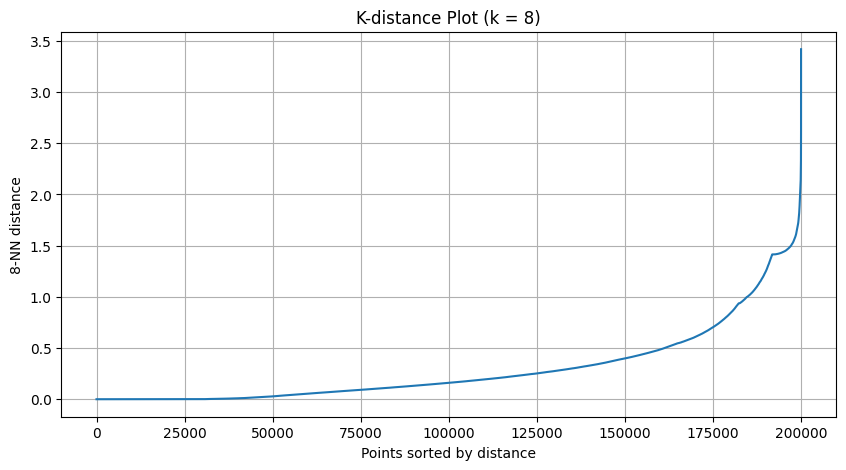

In [4]:
# start with MinPts = 8
min_samples = 8

# set k accordingly 
k = min_samples

# sample data for quicker computation during k-distance plot
df_sample = df_input.sample(n=200000, random_state=42)

# fit NearestNeighbors model
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(df_sample)
distances, indices = neighbors_fit.kneighbors(df_sample)

# k-distance = distance to the k-th nearest neighbor
k_distances = np.sort(distances[:, k-1])

# plot k-distance graph
plt.figure(figsize=(10,5))
plt.plot(k_distances)
plt.title(f'K-distance Plot (k = {k})')
plt.xlabel('Points sorted by distance')
plt.ylabel(f'{k}-NN distance')
plt.grid(True)
plt.show()

The elbow is usually where <ins>concavity changes</ins>. In this case, this point seems to be somewhere between 1.2 and 1.4.

<ins>**Will choose eps = 1.25**</ins>

## Model training

In [ ]:
# use DBSCAN with chosen eps from k-distance plot
eps_value = 1.25  

db = DBSCAN(eps=eps_value, min_samples=min_samples)
labels = db.fit_predict(X)

# Attach cluster labels to your model dataframe
df_model['cluster'] = labels

print("Number of clusters found:", len(set(labels)) - (1 if -1 in labels else 0))
print("Noise points:", sum(labels == -1))

# Cluster insights